# Pistachio Classification

This notebook investigates the dataset ([link to Kaggle](https://www.kaggle.com/datasets/belikesaif/16-attribute-pistachio-dataset/)) with properties of 2 types of pistachio: Kirmizi and Siit. The goal is to predict the type of a pistachio given its properties. The dataset contains 16 different properties (features). The target variable is the pistachio type, and since there are only two types, this is a binary classification problem. Four machine learning models are trained, tuned and evaluated for this goal: `DummyClassifier` (as benchmark), `LogisticRegression`, `RandomForestClassifier`, `xgboost`. The models are cross-validated, and ROC AUC is used as the evaluation criterion to select the best model. 

## Table of Contents

0. [Library Importing](#paragraph0)  
1. [Data Preparation](#paragraph1)  
2. [EDA](#paragraph2)  
    2.1. [Missing Values](#paragraph2.1)  
    2.2. [Target Variable Distribution](#paragraph2.2)  
    2.3. [Feature Distributions](#paragraph2.3)  
    2.4. [Feature Correlation Matrix](#paragraph2.4)  
    2.5. [Correlation with Target](#paragraph2.5)  
3. [Model Training](#paragraph3)  
    3.1. [Data Splitting](#paragraph3.1)  
    3.2. [Dummy Model](#paragraph3.2)  
    3.3. [Logistic Regression](#paragraph3.3)  
    3.4. [Random Forest](#paragraph3.4)  
&emsp;&emsp;3.4.1. [`max_depth` Parameter Tuning](#paragraph3.4.1)  
&emsp;&emsp;3.4.2. [`min_samples_leaf` Parameter Tuning](#paragraph3.4.2)  
&emsp;&emsp;3.4.3. [Best Model](#paragraph3.4.3)  
    3.5. [XGBoost](#paragraph3.5)  
&emsp;&emsp;3.5.1. [`eta` Parameter Tuning](#paragraph3.5.1)  
&emsp;&emsp;3.5.2. [`max_depth` Parameter Tuning](#paragraph3.5.2)  
&emsp;&emsp;3.5.3. [`min_child_weight` Parameter Tuning](#paragraph3.5.3)  
&emsp;&emsp;3.5.4. [Best Model](#paragraph3.5.4)  
4. [Final Model](#paragraph4)  
    4.1. [Model Fitting on `full_train` Dataset](#paragraph4.1)  
    4.2. [Model Saving](#paragraph4.2)  

## 0. Library Importing <a name="paragraph0"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

In [3]:
import xgboost as xgb

In [4]:
import pickle

## 1. Data Preparation <a name="paragraph1"></a>

Loading the dataset:

In [5]:
df = pd.read_csv("Pistachio_Dataset.csv")
df

,id,Area,Perimeter,Major_axis,Minor_axis,Eccentricity,Eqdiasq,Solidity,Covex_area,Extent,Aspect_Ratio,Roundness,Compactness,Shapefactor_1,Shapefactor_2,Shapefactor_3,Shapefactor_4,Class
0,1,63391,1568.4050,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,2,68358,1942.1870,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,3,73589,1246.5380,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,4,71106,1445.2610,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,5,80087,1251.5240,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,2144,85983,1157.1160,444.3447,248.8627,0.8284,330.8730,0.9823,87536,0.6799,1.7855,0.8070,0.7446,0.0052,0.0029,0.5545,0.9900,Siit_Pistachio
2144,2145,85691,2327.3459,439.8794,278.9297,0.7732,330.3107,0.8886,96439,0.6590,1.5770,0.1988,0.7509,0.0051,0.0033,0.5639,0.8892,Siit_Pistachio
2145,2146,101136,1255.6190,475.2161,271.3299,0.8210,358.8459,0.9888,102286,0.7584,1.7514,0.8061,0.7551,0.0047,0.0027,0.5702,0.9987,Siit_Pistachio
2146,2147,97409,1195.2150,452.1823,274.5764,0.7945,352.1718,0.9902,98376,0.7635,1.6468,0.8569,0.7788,0.0046,0.0028,0.6066,0.9989,Siit_Pistachio


Making all column names lowercase and dropping the `id` column, since it is redundant:

In [6]:
df.columns = df.columns.str.lower()
df = df.drop('id', axis=1)
df.head()

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,covex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio


Viewing the datatypes of the columns:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           2148 non-null   int64  
 1   perimeter      2148 non-null   float64
 2   major_axis     2148 non-null   float64
 3   minor_axis     2148 non-null   float64
 4   eccentricity   2148 non-null   float64
 5   eqdiasq        2148 non-null   float64
 6   solidity       2148 non-null   float64
 7   covex_area     2148 non-null   int64  
 8   extent         2148 non-null   float64
 9   aspect_ratio   2148 non-null   float64
 10  roundness      2148 non-null   float64
 11  compactness    2148 non-null   float64
 12  shapefactor_1  2148 non-null   float64
 13  shapefactor_2  2148 non-null   float64
 14  shapefactor_3  2148 non-null   float64
 15  shapefactor_4  2148 non-null   float64
 16  class          2148 non-null   object 
dtypes: float64(14), int64(2), object(1)
memory usage: 28

All feature columns are numeric. Checking the target variable unique values:

In [8]:
df["class"].value_counts()

class
Kirmizi_Pistachio    1232
Siit_Pistachio        916
Name: count, dtype: int64

There are only two values of the target variable. Binary classification model training requres the target variable to take on binary values. Let 1 denote `Kirmizi_Pistachio` and 0 denote `Siit_Pistachio` in the dataset:

In [9]:
df['class'] = (df['class'] == 'Kirmizi_Pistachio').astype(int)

## 2. EDA <a name="paragraph2"></a>

### 2.1. Missing Values <a name="paragraph2.1"></a>

In [10]:
df.isnull().sum()

area             0
perimeter        0
major_axis       0
minor_axis       0
eccentricity     0
eqdiasq          0
solidity         0
covex_area       0
extent           0
aspect_ratio     0
roundness        0
compactness      0
shapefactor_1    0
shapefactor_2    0
shapefactor_3    0
shapefactor_4    0
class            0
dtype: int64

There are no missing values in the dataset.

### 2.2. Target Variable Distribution <a name="paragraph2.2"></a>

Plotting the frequency distribution of the `class` target variable:

<Axes: title={'center': 'Target Variable Frequency'}, xlabel='Class', ylabel='Count'>

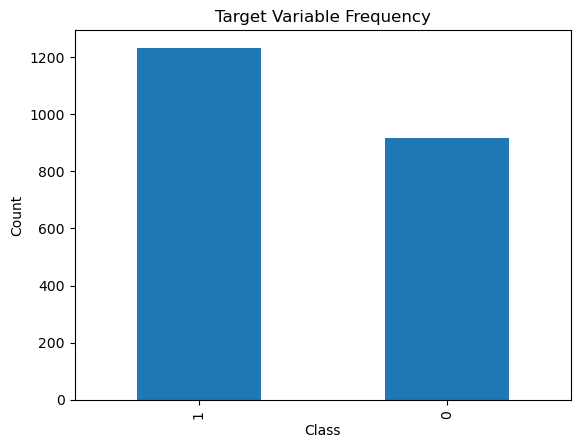

In [11]:
class_count = df["class"].value_counts()
class_count.plot(kind="bar",
                 xlabel="Class",
                 ylabel="Count",
                 title="Target Variable Frequency")

The target variable is slightly unbalanced. Checking their relative frequency:

In [12]:
class_count / class_count.sum()

class
1    0.573557
0    0.426443
Name: count, dtype: float64

Thus, there are around 57% `Kirmizi_Pistachio` and 43% `Siit_Pistachio` records in the dataset. A dummy model that predicts every pistachio as Kirmizi would have around 57% accuracy.

### 2.3. Feature Distributions <a name="paragraph2.3"></a>

Defining the list of feature names:

In [13]:
features = list(df.columns)
features.remove('class')
features

['area',
 'perimeter',
 'major_axis',
 'minor_axis',
 'eccentricity',
 'eqdiasq',
 'solidity',
 'covex_area',
 'extent',
 'aspect_ratio',
 'roundness',
 'compactness',
 'shapefactor_1',
 'shapefactor_2',
 'shapefactor_3',
 'shapefactor_4']

Viewing the feature statistics in numerical format:

In [14]:
df[features].describe()

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,covex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,79950.655493,1425.971751,446.248968,238.311842,0.840219,317.919173,0.940093,85015.839851,0.716067,1.898154,0.569172,0.713077,0.005701,0.003017,0.510461,0.955239
std,13121.737799,375.565503,32.445304,30.310695,0.048759,26.908600,0.050452,13154.919327,0.052532,0.240100,0.212760,0.044547,0.000817,0.000340,0.063942,0.051840
min,29808.000000,858.363000,320.344500,133.509600,0.504900,194.814600,0.588000,37935.000000,0.427200,1.158500,0.062800,0.476000,0.004000,0.002400,0.226600,0.620400
25%,71936.750000,1170.996250,426.508750,217.875825,0.817500,302.642850,0.919850,76467.000000,0.687000,1.736375,0.371250,0.681550,0.005200,0.002800,0.464475,0.944000
50%,79905.500000,1262.785500,448.574750,236.416350,0.849650,318.965300,0.954150,85075.500000,0.726500,1.896250,0.643400,0.710700,0.005600,0.003000,0.505150,0.973100
75%,89030.500000,1607.906250,468.509400,257.760150,0.875200,336.685525,0.976925,93893.500000,0.753600,2.067025,0.744125,0.741650,0.006100,0.003200,0.550075,0.987300
max,124008.000000,2755.049100,541.966100,383.046100,0.946000,397.356100,0.995100,132478.000000,0.820400,3.085800,0.933600,0.877900,0.013100,0.005300,0.770600,0.999000


Plotting the distribution of each feature distinguished by class:

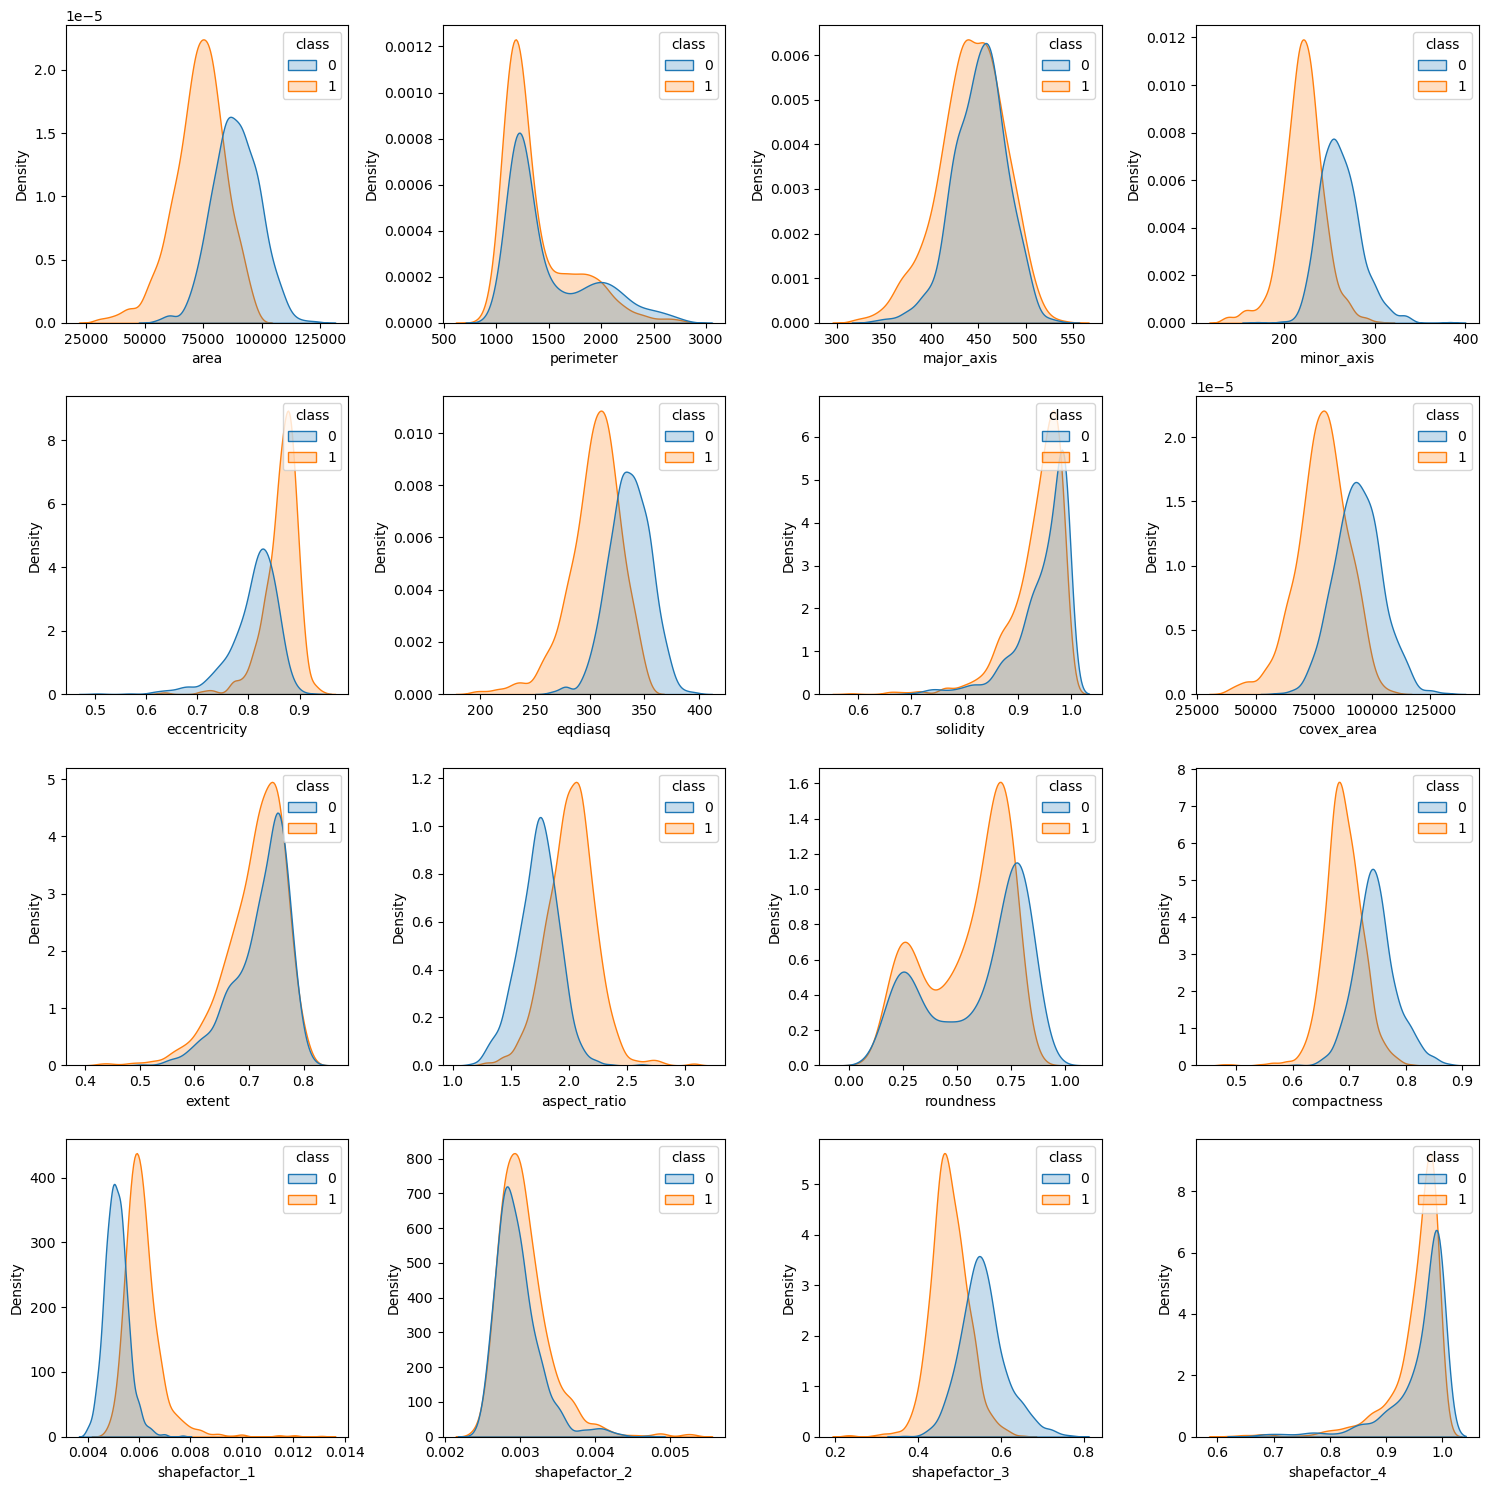

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
feature_id = 0

for i in range(4):
    for j in range(4):
        feature = features[feature_id]
        sns.kdeplot(df, x=feature, hue='class', ax=axs[i, j], fill=True)
        feature_id += 1

plt.tight_layout()
plt.show()

The following observations can be made:
- Not all features are normally distributed. Some distributions are positively/negatively skewed, some are bimodal.
- `area`, `minor_axis`, `eccentricity`, `eqdiasq`, `covex_area`, `aspect_ratio`, `compactness`, `shapefactor_1`, `shapefactor_3` have noticeable differences in mean value for the two classes.

### 2.4. Feature Correlation Matrix <a name="paragraph2.4"></a>

Plotting the feature correlation matrix as a heatmap:

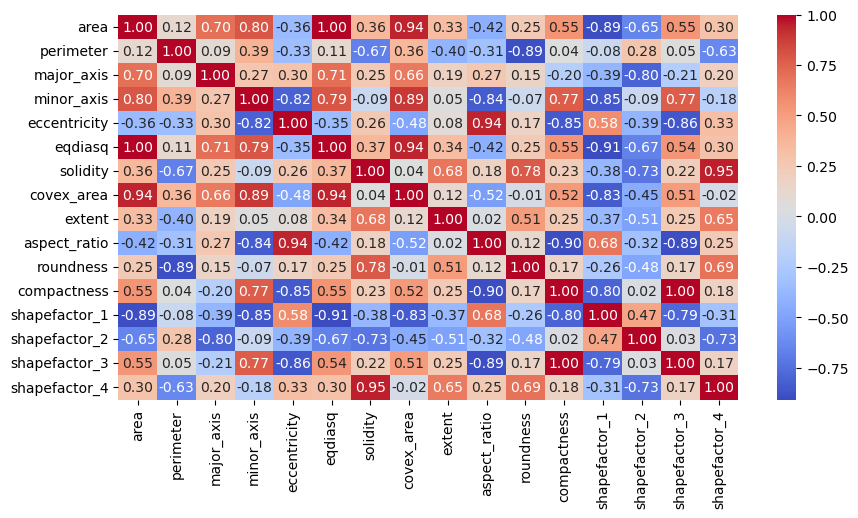

In [16]:
corr = df[features].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Selecting the feature pairs with high correlation (>0.7) and putting them in `corr_pairs` dataframe:

In [17]:
corr_pairs = pd.DataFrame(columns=['feature 1', 'feature 2', 'corr_coef'])
for feature_id, feature in enumerate(features):
    # Extract a single correlation matrix column as a series
    corr_col = corr[feature]
    # Keep the elements below the diagonal
    corr_col = corr_col.iloc[feature_id+1:]
    # Select values with high correlation coefficient
    filtered_corr_col = corr_col[(abs(corr[feature]) >= 0.7)]
    for feature_pair, corr_coef in filtered_corr_col.items():
        # Append the feature, its pair and the corresponding coefficient as a new row
        corr_pairs.loc[len(corr_pairs)] = [feature, feature_pair, corr_coef]        

Viewing the top highly correlated feature pairs:

In [18]:
corr_pairs.sort_values(by='corr_coef', key=abs, ascending=False)

,feature 1,feature 2,corr_coef
26,compactness,shapefactor_3,0.998625
1,area,eqdiasq,0.997399
21,solidity,shapefactor_4,0.949501
2,area,covex_area,0.943877
14,eccentricity,aspect_ratio,0.943751
17,eqdiasq,covex_area,0.940651
18,eqdiasq,shapefactor_1,-0.906893
23,aspect_ratio,compactness,-0.896857
24,aspect_ratio,shapefactor_3,-0.892523
3,area,shapefactor_1,-0.892493


A number of feature pairs exhibit high correlation, since some geometric properties are very similar.

### 2.5. Correlation with Target <a name="paragraph2.5"></a>

Viewing the ranking of feature correlation with the target:

In [19]:
df[features].corrwith(df['class']).sort_values(key=abs, ascending=False)

minor_axis      -0.668126
shapefactor_3   -0.626304
compactness     -0.624939
shapefactor_1    0.615513
area            -0.589226
covex_area      -0.584618
aspect_ratio     0.581469
eqdiasq         -0.577300
eccentricity     0.546759
perimeter       -0.145290
major_axis      -0.136845
shapefactor_2    0.126188
solidity        -0.125347
roundness       -0.105768
extent          -0.100200
shapefactor_4   -0.063084
dtype: float64

9/16 features exhibit moderate/high correlation with the target (>0.5). 7/16 features have low correlation with the target (<0.2).

## 3. Model Training <a name="paragraph3"></a>

### 3.1. Data Splitting <a name="paragraph3.1"></a>

Splitting the data in 60%/20%/20% parts:

In [20]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=23)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=23)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Assigning the values to the target vector:

In [21]:
y_full_train = df_full_train['class'].values
y_train = df_train['class'].values
y_val = df_val['class'].values
y_test = df_test['class'].values

Since all features in the dataset are numerical, one-hot encoding is not required. The feature matrices are obtained straight from the corresponding dataframes:

In [22]:
X_full_train = df_full_train[features].values
X_train = df_train[features].values
X_val = df_val[features].values
X_test = df_test[features].values

### 3.2. Dummy Model <a name="paragraph3.2"></a>

Training a dummy model:

In [23]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

y_pred = dummy_model.predict_proba(X_val)[:, 1]

Evaluating the model with ROC AUC:

In [24]:
roc_auc_score(y_val, y_pred)

0.5

### 3.3. Logistic Regression <a name="paragraph3.3"></a>

Defining a range of regularization parameter values to tune the model:

In [25]:
C_values = 10 ** np.arange(-6, 7, dtype='float')

Evaluating the logistic regression model with different regularization strength using cross validation with 5 folds. For each iteration, the ROC AUC score is taken as the mean value across all folds with the standard deviation also shown.  

In [26]:
for C in C_values:
    log_reg = LogisticRegression(C=C, max_iter=1000, random_state=23)
    cv_result = cross_validate(log_reg, X_full_train, y_full_train, scoring='roc_auc')
    scores = cv_result['test_score']    
    print(f'C={C:<10} score={scores.mean():.3f}+-{scores.std():.3f}')

C=1e-06      score=0.902+-0.015
C=1e-05      score=0.928+-0.009
C=0.0001     score=0.931+-0.007
C=0.001      score=0.931+-0.006
C=0.01       score=0.931+-0.007
C=0.1        score=0.931+-0.006
C=1.0        score=0.931+-0.006
C=10.0       score=0.931+-0.006
C=100.0      score=0.931+-0.006
C=1000.0     score=0.932+-0.007
C=10000.0    score=0.932+-0.007
C=100000.0   score=0.932+-0.007
C=1000000.0  score=0.932+-0.007


The values of regularization parameter `C` less than 0.0001 reduce the score. On the other hand, the score does not improve significantly when `C` is above 1000. Thus, the model with `C=1000` and ROC AUC score of 0.932+-0.007 is the most optimal.

### 3.4. Random Forest <a name="paragraph3.4"></a>

Defining lists of parameters for tuning the random forest model:

In [27]:
max_depth_list = [3, 5, 10, 20]
min_samples_leaf_list = max_depth_list
n_estimators_list = range(10, 201, 10)

#### 3.4.1. `max_depth` Parameter Tuning <a name="paragraph3.4.1"></a>

Evaluating the random forest model with different `max_depth` and `n_estimators` combinations using cross validation with 5 folds (for each combination, the mean ROC AUC score across all folds is recorded into `scores_by_max_depth` list):

In [28]:
scores_by_max_depth = []

for d in max_depth_list:
    for n in n_estimators_list:
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=23,
                                    n_jobs=-1)
        
        cv_result = cross_validate(rf, X_full_train, y_full_train, scoring='roc_auc')
        score = cv_result['test_score'].mean()  
        scores_by_max_depth.append((d, n, score))

Plotting the ROC AUC vs `n_estimators` curve for each `max_depth` using the scores collected above:

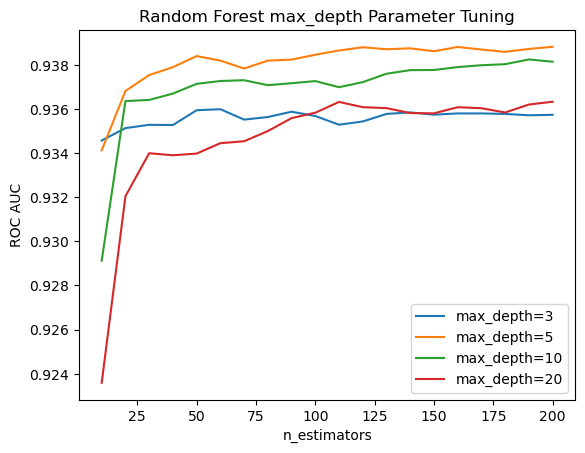

In [29]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores_by_max_depth, columns=columns)

for d in max_depth_list:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.xlabel("n_estimators")
plt.ylabel("ROC AUC")
plt.title('Random Forest max_depth Parameter Tuning')
plt.legend()
plt.show()

At `max_depth=5` the model performs best at all `n_estimators`, so this value is selected:

In [30]:
max_depth = 5

#### 3.4.2. `min_samples_leaf` Parameter Tuning <a name="paragraph3.4.2"></a>

Evaluating the random forest model at `max_depth=5` with different `min_samples_leaf` and `n_estimators` combinations using cross validation with 5 folds (for each combination the mean ROC AUC score across all folds is recorded into `scores_by_min_samples_leaf` list):

In [31]:
scores_by_min_samples_leaf = []

for s in min_samples_leaf_list:
    for n in n_estimators_list:
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=23,
                                    n_jobs=-1)
        
        cv_result = cross_validate(rf, X_full_train, y_full_train, scoring='roc_auc')
        score = cv_result['test_score'].mean()  
        scores_by_min_samples_leaf.append((s, n, score))

Plotting the ROC AUC vs `n_estimators` curve for each `min_samples_leaf` using the scores collected above:

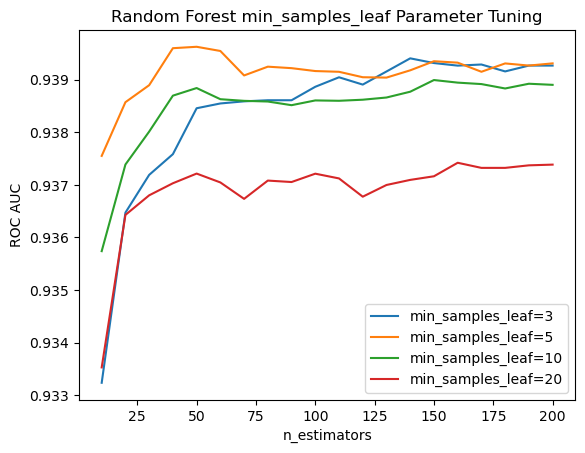

In [32]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores_by_min_samples_leaf, columns=columns)

for s in min_samples_leaf_list:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='min_samples_leaf=%d' % s)

plt.xlabel("n_estimators")
plt.ylabel("ROC AUC")
plt.title('Random Forest min_samples_leaf Parameter Tuning')
plt.legend()
plt.show()

The best score is achieved with `min_samples_leaf=5` at `n_estimators` equal to around 50. Thus, these parameters are selected:

In [33]:
min_samples_leaf = 5
n_estimators = 50

#### 3.4.3. Best Model <a name="paragraph3.4.3"></a>

Evaluating the final random forest model with the selected parameters:

In [34]:
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=23,
                            n_jobs=-1)

cv_result = cross_validate(rf, X_full_train, y_full_train, scoring='roc_auc')
scores = cv_result['test_score']    
print(f'score = {scores.mean():.3f} +- {scores.std():.3f}')

score = 0.940 +- 0.006


Extracting feature importance information from fitting the model on the train dataset:

In [35]:
rf.fit(X_train, y_train)
feature_importances_table = pd.DataFrame()
feature_importances_table['feature'] = features
feature_importances_table['importance'] = rf.feature_importances_
feature_importances_table.sort_values(by='importance', ascending=False)

,feature,importance
3,minor_axis,0.223422
12,shapefactor_1,0.186722
11,compactness,0.138401
14,shapefactor_3,0.112958
0,area,0.066154
9,aspect_ratio,0.052703
5,eqdiasq,0.052125
4,eccentricity,0.043835
15,shapefactor_4,0.043483
7,covex_area,0.030980


The random forest feature importance ranking is very similar to how the features correlate with the target variable (see Section Correlation with Target): `minor_axis`, `shapefactor_1`, `compactness`, `shapefactor_3` and `area` are the top 5 features in both cases.

### 3.5. XGBoost <a name="paragraph3.5"></a>

Creating feature matrices for XGBoost model:

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Defining a watch list for model training process:

In [37]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

Defining a function for parsing the model training output:

In [38]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

The XGBoost parameters selected for tuning and their ranges are:
- `eta`: 0.01, 0.05, 0.1, 0.3, 1.0
- `max_depth`: 3, 4, 6, 10
- `min_child_weight`: 1, 10, 30

The default values for these parameters are:

In [39]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 4,
    'seed': 23,
    'verbosity': 1,
}

#### 3.5.1. `eta` Parameter Tuning <a name="paragraph3.5.1"></a>

Creating a dictionary to store the scores of models with different `eta`:

In [40]:
scores_by_eta = {}

Evaluating the model at `eta=0.01`:

In [41]:
%%capture output

xgb_params['eta'] = 0.01
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [42]:
key = xgb_params['eta']
scores_by_eta[key] = parse_xgb_output(output)

Evaluating the model at `eta=0.05`:

In [43]:
%%capture output

xgb_params['eta'] = 0.05
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [44]:
key = xgb_params['eta']
scores_by_eta[key] = parse_xgb_output(output)

Evaluating the model at `eta=0.1`:

In [45]:
%%capture output

xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [46]:
key = xgb_params['eta']
scores_by_eta[key] = parse_xgb_output(output)

Evaluating the model at `eta=0.3`:

In [47]:
%%capture output

xgb_params['eta'] = 0.3
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [48]:
key = xgb_params['eta']
scores_by_eta[key] = parse_xgb_output(output)

Evaluating the model at `eta=1.0`:

In [49]:
%%capture output

xgb_params['eta'] = 1.0
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [50]:
key = xgb_params['eta']
scores_by_eta[key] = parse_xgb_output(output)

Plotting the collected scores versus iterations for each `eta`:

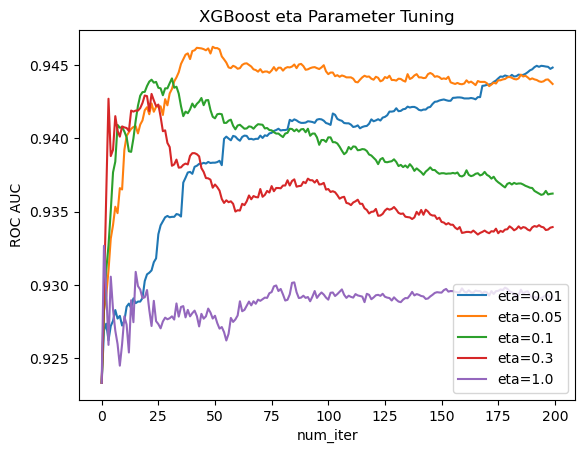

In [51]:
for eta, df_score in scores_by_eta.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=f'eta={eta}')

plt.xlabel("num_iter")
plt.ylabel("ROC AUC")
plt.title('XGBoost eta Parameter Tuning')
plt.legend()
plt.show()

The best performance is achieved when `eta=0.05`. The curve for `eta=0.01` may reach a higher score with more iterations, but the learning rate is too slow within the selected bounds.

In [52]:
xgb_params['eta'] = 0.05

#### 3.5.2. `max_depth` Parameter Tuning <a name="paragraph3.5.2"></a>

Creating a dictionary to store the scores of models with different `max_depth`:

In [53]:
scores_by_max_depth = {}

Evaluating the model at `max_depth=3`:

In [54]:
%%capture output

xgb_params['max_depth'] = 3
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [55]:
key = xgb_params['max_depth']
scores_by_max_depth[key] = parse_xgb_output(output)

Evaluating the model at `max_depth=4`:

In [56]:
%%capture output

xgb_params['max_depth'] = 4
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [57]:
key = xgb_params['max_depth']
scores_by_max_depth[key] = parse_xgb_output(output)

Evaluating the model at `max_depth=6`:

In [58]:
%%capture output

xgb_params['max_depth'] = 6
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [59]:
key = xgb_params['max_depth']
scores_by_max_depth[key] = parse_xgb_output(output)

Evaluating the model at `max_depth=10`:

In [60]:
%%capture output

xgb_params['max_depth'] = 10
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [61]:
key = xgb_params['max_depth']
scores_by_max_depth[key] = parse_xgb_output(output)

Plotting the collected scores versus iterations for each `max_depth`:

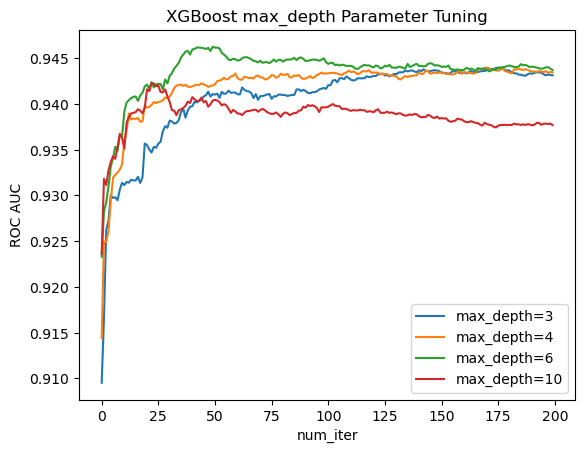

In [62]:
for max_depth, df_score in scores_by_max_depth.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=f'max_depth={max_depth}')

plt.xlabel("num_iter")
plt.ylabel("ROC AUC")
plt.title('XGBoost max_depth Parameter Tuning')
plt.legend()
plt.show()

The best performance is achieved when `max_depth=6`.

In [63]:
xgb_params['max_depth'] = 6

#### 3.5.3. `min_child_weight` Parameter Tuning <a name="paragraph3.5.3"></a>

Creating a dictionary to store the scores of models with different `min_child_weight`:

In [64]:
scores_by_min_child_weight = {}

Evaluating the model at `min_child_weight=1`:

In [65]:
%%capture output

xgb_params['min_child_weight'] = 1
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [66]:
key = xgb_params['min_child_weight']
scores_by_min_child_weight[key] = parse_xgb_output(output)

Evaluating the model at `min_child_weight=10`:

In [67]:
%%capture output

xgb_params['min_child_weight'] = 10
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [68]:
key = xgb_params['min_child_weight']
scores_by_min_child_weight[key] = parse_xgb_output(output)

Evaluating the model at `min_child_weight=30`:

In [69]:
%%capture output

xgb_params['min_child_weight'] = 30
model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

In [70]:
key = xgb_params['min_child_weight']
scores_by_min_child_weight[key] = parse_xgb_output(output)

Plotting the collected scores versus iterations for each `min_child_weight`:

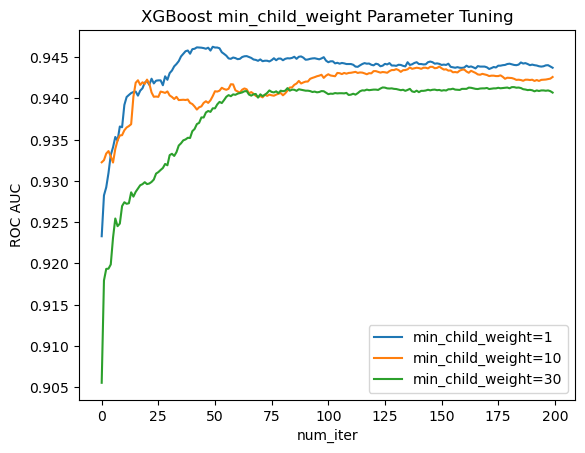

In [71]:
for min_child_weight, df_score in scores_by_min_child_weight.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=f'min_child_weight={min_child_weight}')

plt.xlabel("num_iter")
plt.ylabel("ROC AUC")
plt.title('XGBoost min_child_weight Parameter Tuning')
plt.legend()
plt.show()

Increasing the `min_child_weight` from the default value reduces the performance, so the value of 1 is selected for the final model.

In [72]:
xgb_params['min_child_weight'] = 1

#### 3.5.4. Best Model <a name="paragraph3.5.4"></a>

Viewing the selected model parameters (`verbosity` turned off as no longer needed):

In [73]:
xgb_params['verbosity'] = 0
xgb_params

{'eta': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 4,
 'seed': 23,
 'verbosity': 0}

The best score achieved when tuning the parameters was at 50 iterations:

In [74]:
num_boost_round=50

Using 5-fold cross-validation to determine the mean AUC score and the corresponding standard deviation:

In [75]:
kfold = KFold(n_splits=5, shuffle=True, random_state=23)

xgb_cv_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = df_train_fold['class'].values
    y_val_fold = df_val_fold['class'].values
    
    X_train_fold = df_train_fold[features].values
    X_val_fold = df_val_fold[features].values
    
    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, feature_names=features)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, feature_names=features)
    
    model = xgb.train(xgb_params, dtrain_fold, num_boost_round=num_boost_round)
    y_pred_fold = model.predict(dval_fold)
    
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    xgb_cv_scores.append(auc)

print('score = %.3f +- %.3f' % (np.mean(xgb_cv_scores), np.std(xgb_cv_scores)))

score = 0.940 +- 0.012


## 4. Final Model <a name="paragraph4"></a>

Summary of the ROC AUC scores obtained with different models:
1. `DummyClassifier`: 0.5
2. `LogisticRegression`: 0.932 +- 0.007
3. `RandomForestClassifier`: 0.940 +- 0.006
4. `XGBoost`: 0.940 +- 0.012

The Random Forest and XGBoost models have the same mean score, but the Random Forest is more stable (has lower deviation) when cross-validated. Thus, the final selected model is `RandomForestClassifier` with the following parameters:

In [76]:
n_estimators=50
max_depth=5
min_samples_leaf=5

### 4.1. Model Fitting on `full_train` Dataset <a name="paragraph4.1"></a>

Using `full_train` dataset to fit the final model:

In [77]:
rf = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=23,
                            n_jobs=-1)

rf.fit(X_full_train, y_full_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=23)

Evaluating the final model on the `test` dataset:

In [78]:
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9533417402269861

In [79]:
(0.953 - 0.940) / 0.940 * 100

1.3829787234042565

The ROC AUC score of the final model on the test dataset improved by 1.4%.

Selecting the threshold value based on the intersection of the precision and recall curves:

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

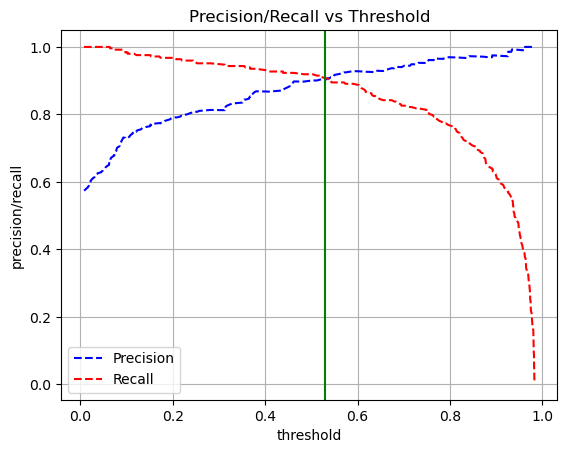

In [81]:
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'r--', label='Recall')
plt.axvline(x=0.53, color='g')
plt.xlabel("threshold")
plt.ylabel("precision/recall")
plt.title('Precision/Recall vs Threshold')
plt.grid()
plt.legend()
plt.show()

The curves intersect at the threshold value of around 0.53, which is very close to the default value for a balanced dataset (0.5). Hence, in predictions, the default value will be used.

### 4.2. Model Saving <a name="paragraph4.2"></a>

Saving the final model using `pickle`:

In [82]:
output_file = 'model.bin'

In [83]:
with open(output_file, 'wb') as f_out: 
    pickle.dump(rf, f_out)